Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
# score_name = "quality"
score_name = "linear_score"
m_train_examples: int = 200
m_test_examples: int = 200
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,64,0,2,5467,0,3,5343,0,4,1543,0
1,0,4390,0,1,5815,0,2,5865,1,3,5798,0,4,2083,0
2,0,599,0,1,3610,0,2,4821,1,3,2147,0,4,4012,0
3,0,1392,1,1,6388,0,2,3709,0,3,1309,0,4,4570,0
4,0,2063,0,1,312,1,2,551,0,3,6144,0,4,1883,0


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.435
1,pick_value_1,0.210
2,pick_value_2,0.165
3,pick_value_3,0.080
4,pick_value_4,0.110


In [18]:
# TODO: better estimate here
p_continue_est = np.mean( 
    (np.array(win_frequencies['win frequency'][range(1, win_frequencies.shape[0])]) + 1e-2)
 / (np.array(win_frequencies['win frequency'][range(0, win_frequencies.shape[0] - 1)]) + 1e-2)
)

p_continue_est

0.7843639038863758

In [19]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,64,0,5467,0,5343,0,1543,0
1,4390,0,5815,0,5865,1,5798,0,2083,0
2,599,0,3610,0,4821,1,2147,0,4012,0
3,1392,1,6388,0,3709,0,1309,0,4570,0
4,2063,0,312,1,551,0,6144,0,1883,0
5,2010,0,1494,0,5669,1,3843,0,5500,0
6,5903,0,5988,1,5107,0,5769,0,4815,0
7,5194,1,2787,0,1050,0,5149,0,1700,0
8,5946,1,2953,0,4371,0,895,0,4712,0
9,6469,1,536,0,2016,0,2200,0,5126,0


In [20]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [21]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=p_continue_est,
)
fit = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of reading on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of it

In [22]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-301.127
1,-311.536
2,-299.891
3,-289.956
4,-300.974
...,...
3995,-312.815
3996,-304.928
3997,-277.845
3998,-281.681


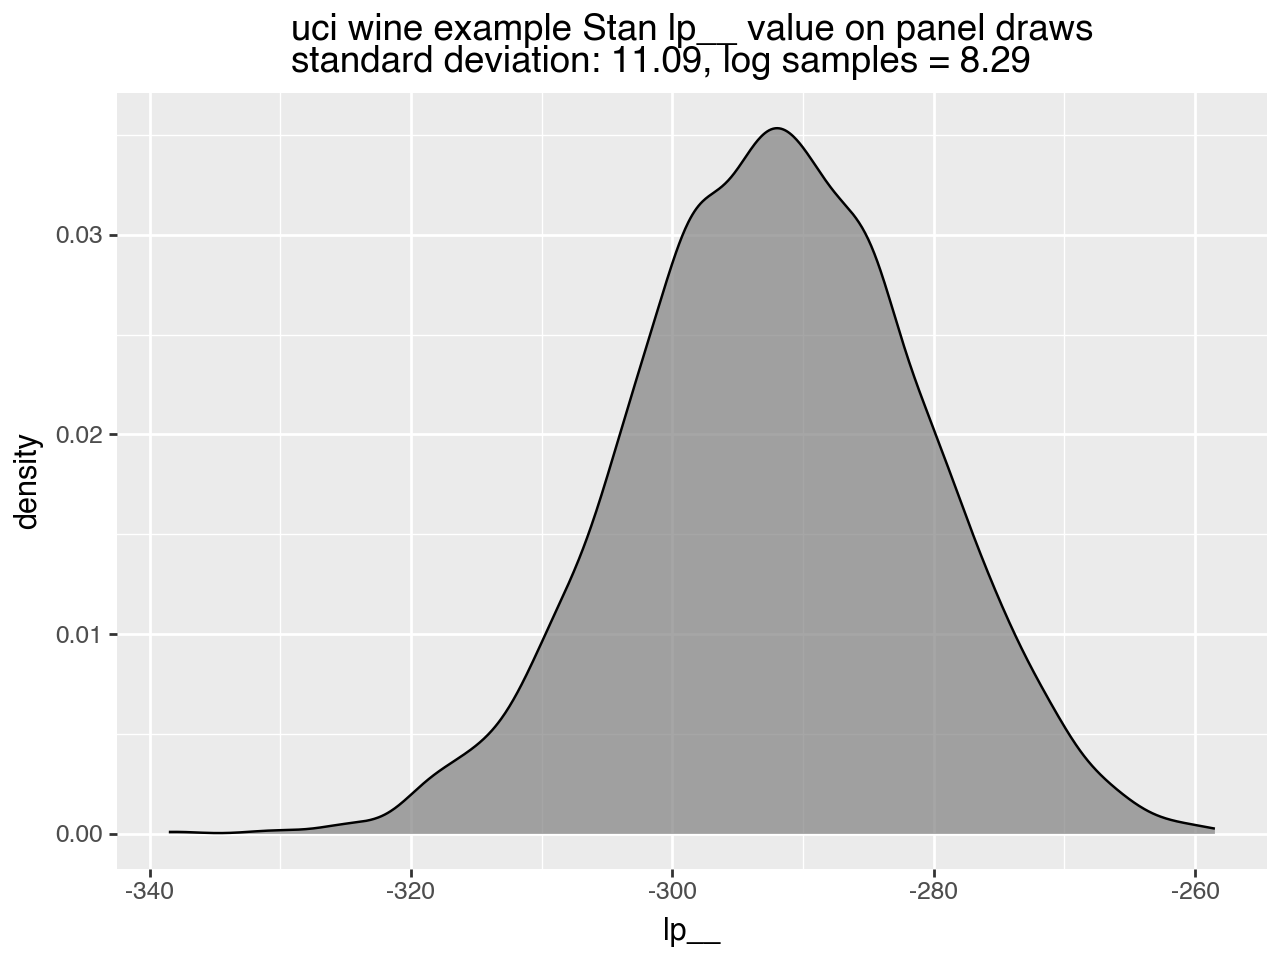

In [23]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [24]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,1.098730,-1.583530,2.09729,-0.006115,-16.070500,-0.148586,0.055797,-7.50945,-6.429630,9.35415,...,10.693500,0.370275,0.281857,0.042084,-0.024349,12.894700,-5.133660,1.467850,5.29919,-3.58246
1,1.260800,-8.496980,-1.92029,1.773590,-17.721600,-0.224863,0.039590,-27.51930,-1.144540,-3.44210,...,12.275100,0.734449,-1.762320,-0.006014,-0.011074,6.861450,-3.210790,5.080100,5.59743,12.44550
2,1.737820,-14.400500,2.42683,-3.205150,12.113200,0.305421,0.052625,12.53830,-5.006280,-6.39022,...,-0.980216,0.423040,-4.793880,0.142520,-0.051357,0.933184,2.488220,-1.176330,4.34885,-16.84830
3,1.549210,-18.281200,1.67469,-2.038240,7.607730,0.378186,0.089006,13.34490,-1.783650,-10.36080,...,-3.084500,0.545833,-13.798400,0.083948,-0.055266,-11.221100,5.997640,-7.347540,5.49311,-13.56070
4,2.354560,-7.830430,-6.99401,-0.976623,-3.766380,0.325579,0.014558,-12.02460,0.042634,-1.18915,...,0.775719,1.122900,-7.619040,-0.035323,-0.033095,17.149900,7.038920,0.730113,6.35760,10.60210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.507843,1.259260,12.16110,-0.354180,14.971200,-0.080211,0.027635,-11.56990,-7.639840,-2.03170,...,4.913270,0.889465,-17.428900,0.059331,-0.090229,-1.497860,-2.743110,11.940000,4.43078,-7.21620
3996,-0.633168,0.421519,8.90774,0.342916,11.616500,-0.159107,0.064037,-9.50531,-8.593670,-2.88399,...,7.243090,0.852311,-11.378600,0.052582,-0.099348,-2.585960,-2.746430,12.206600,3.94842,-8.96269
3997,0.031037,-17.074700,-7.98072,-0.932161,0.860277,-0.049430,0.026355,6.03786,-7.138380,13.88160,...,5.987440,0.574950,3.412360,0.188161,-0.060389,-7.075030,-4.167800,-1.795300,4.93783,-0.21575
3998,0.297470,-2.235350,1.89945,-2.185170,3.055980,0.123630,0.056429,-3.92031,-12.940300,-19.98200,...,6.510720,0.255871,-5.174600,-0.125423,0.056560,16.543600,-10.323100,6.158050,5.52579,1.50346


In [25]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red              0.717288
volatile acidity is red         -12.086166
citric acid is red               -2.457781
residual sugar is red            -0.946084
chlorides is red                  2.644910
free sulfur dioxide is red       -0.044360
total sulfur dioxide is red       0.063912
density is red                   -0.054254
pH is red                        -7.661745
sulphates is red                 -3.408802
alcohol is red                    4.875493
fixed acidity is white           -2.449033
volatile acidity is white       -13.030870
citric acid is white              3.261584
residual sugar is white           0.489612
chlorides is white               -2.247017
free sulfur dioxide is white      0.039522
total sulfur dioxide is white    -0.021486
density is white                 -0.271221
pH is white                      -2.870711
sulphates is white                3.474641
alcohol is white                  4.756292
is_red                            0.153874
dtype: floa

In [26]:
estimated_beta_Stan = list(estimated_beta_Stan) + [0] * n_alternatives  # TODO: clean

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2235,True
1,0,1,0.1001,False
2,0,2,0.4216,False
3,0,3,0.2059,False
4,0,4,0.0489,False
5,1,0,0.0524,True
6,1,1,0.1554,False
7,1,2,0.3003,False
8,1,3,0.2299,False
9,1,4,0.2620,False


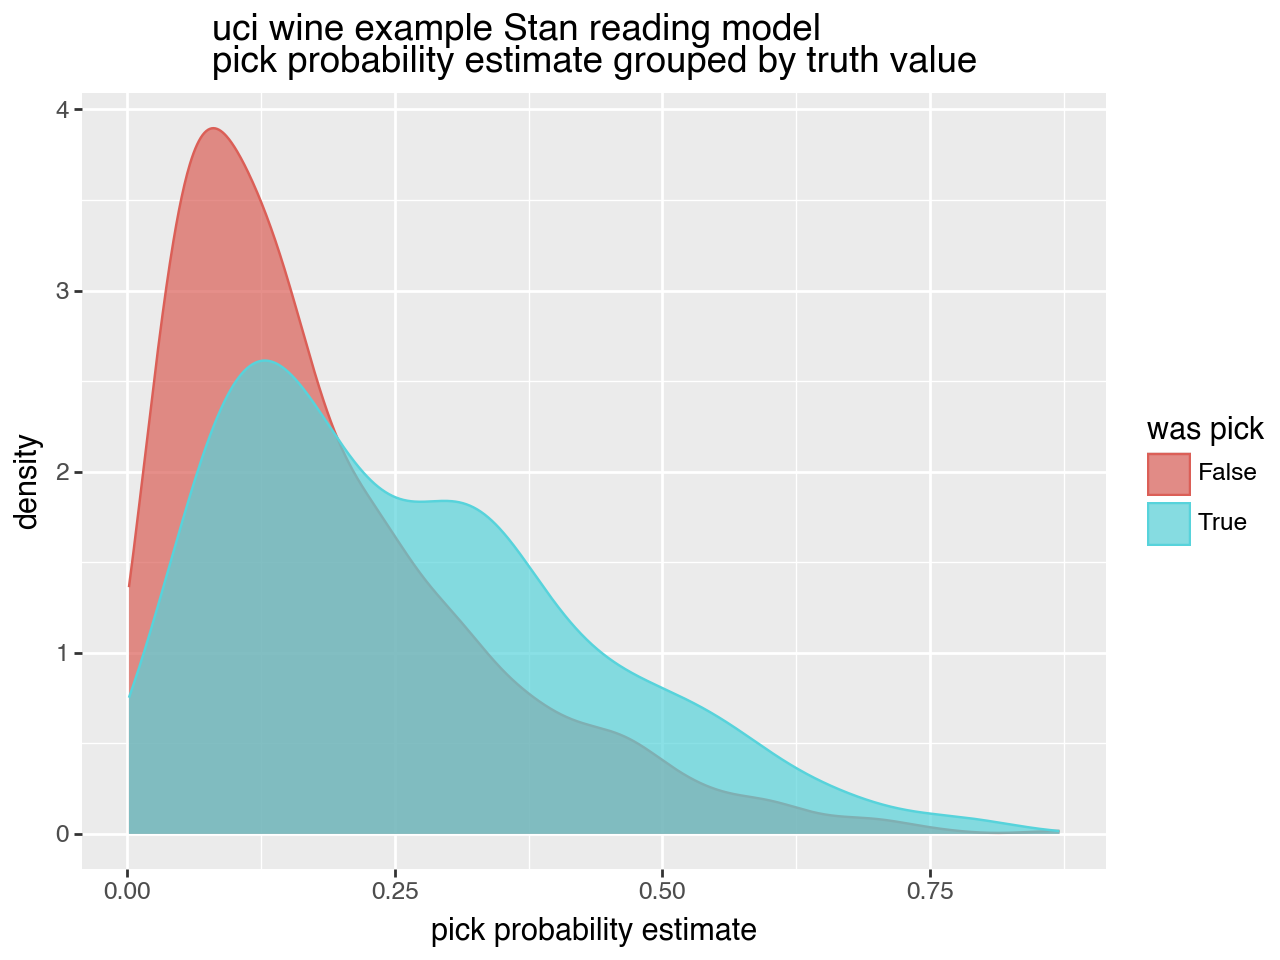

<Figure size 640x480 with 0 Axes>

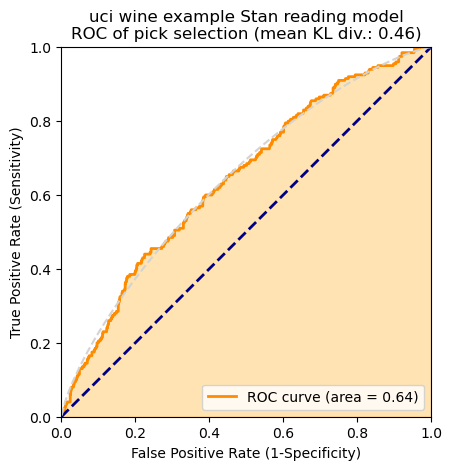

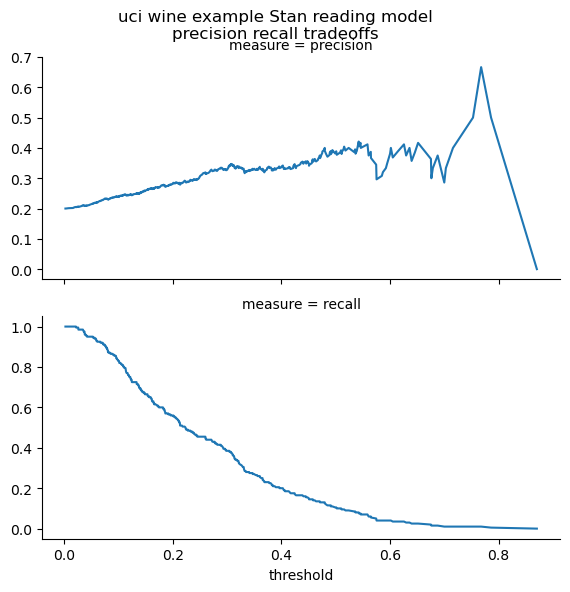

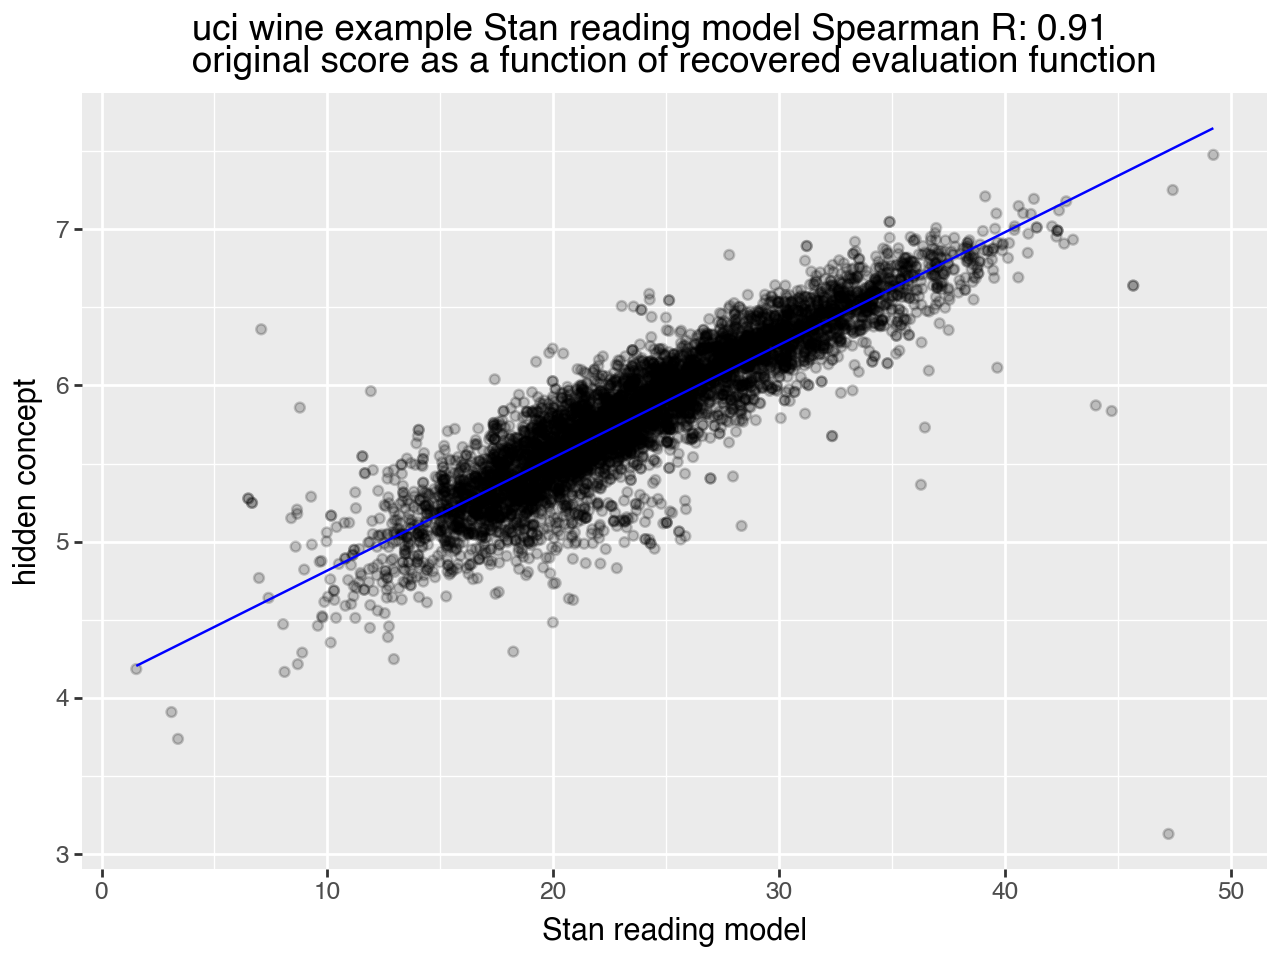

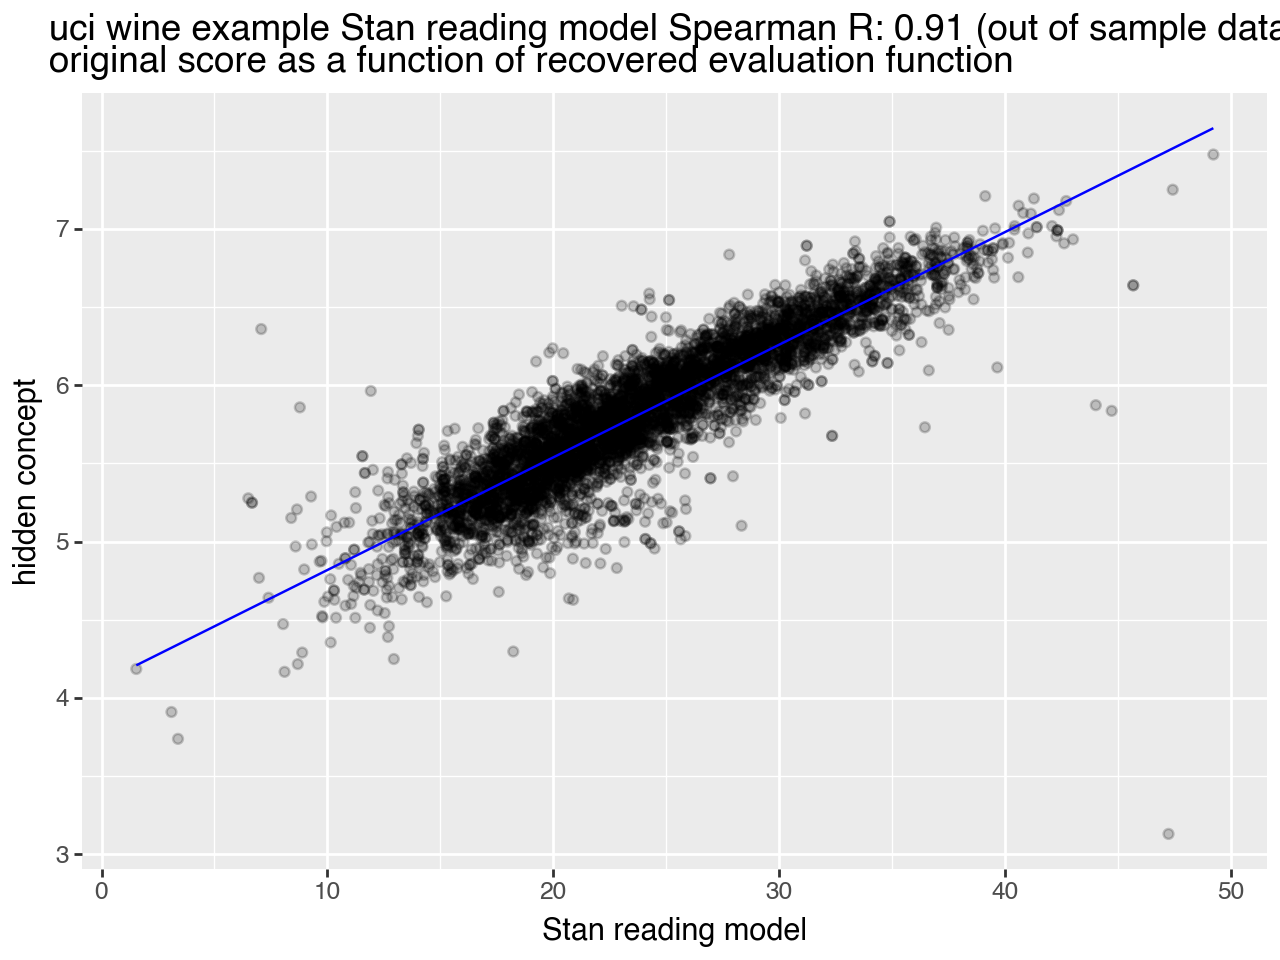

In [27]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [28]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [29]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [30]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2365,True
1,0,1,0.1986,False
2,0,2,0.2235,False
3,0,3,0.1821,False
4,0,4,0.1593,False
5,1,0,0.2040,True
6,1,1,0.2122,False
7,1,2,0.2086,False
8,1,3,0.1870,False
9,1,4,0.1882,False


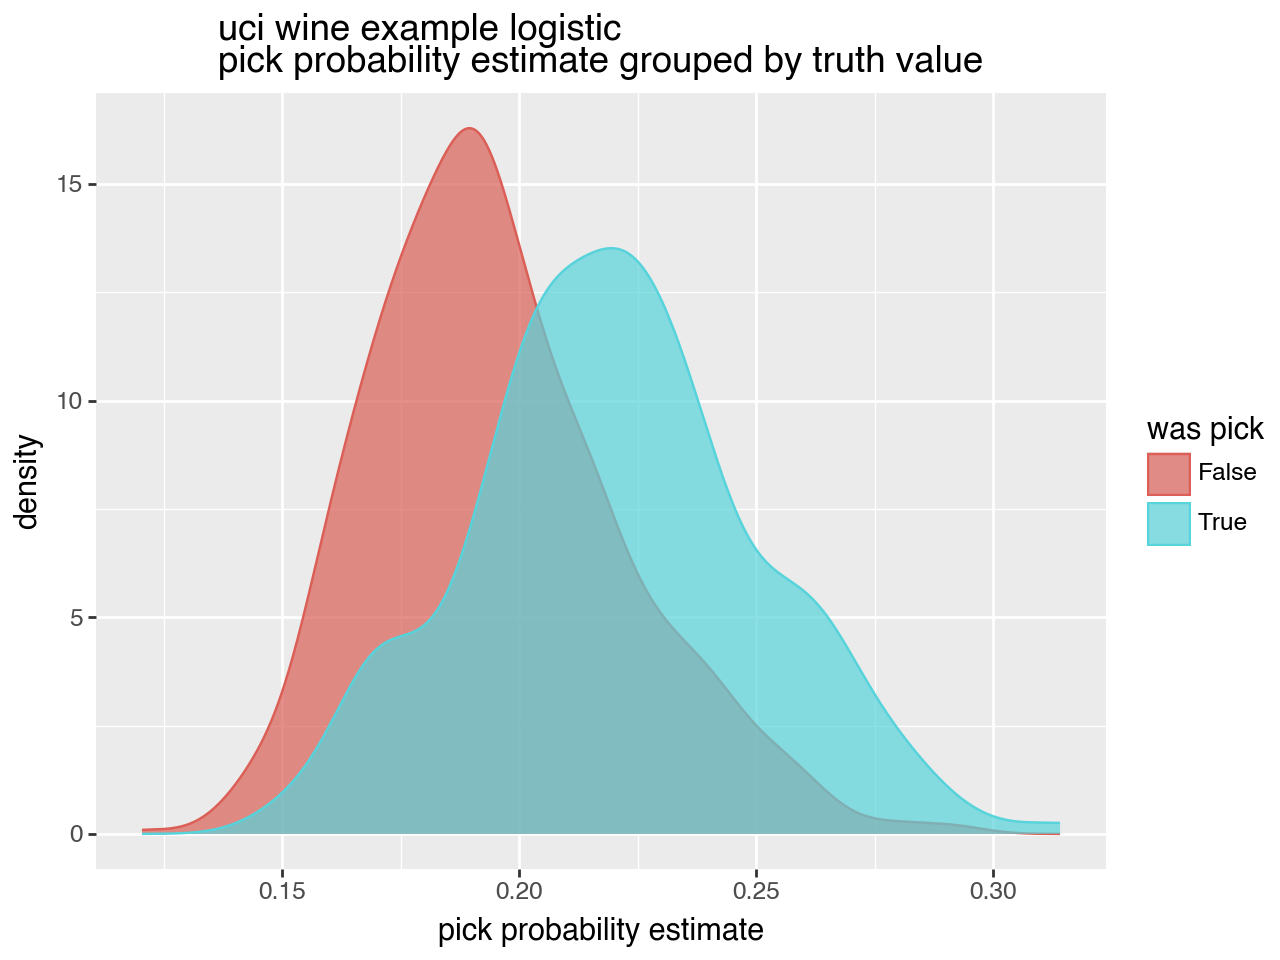

<Figure size 640x480 with 0 Axes>

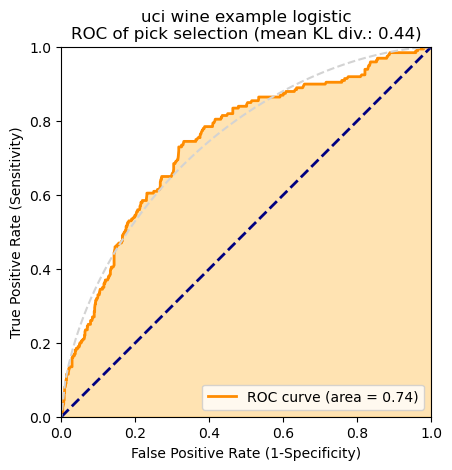

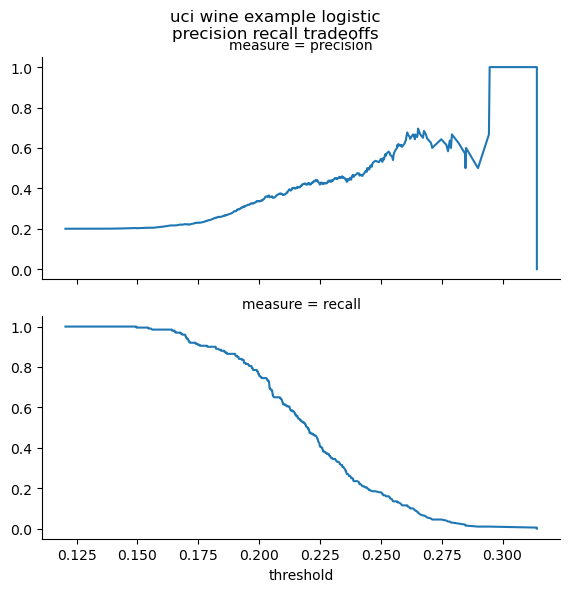

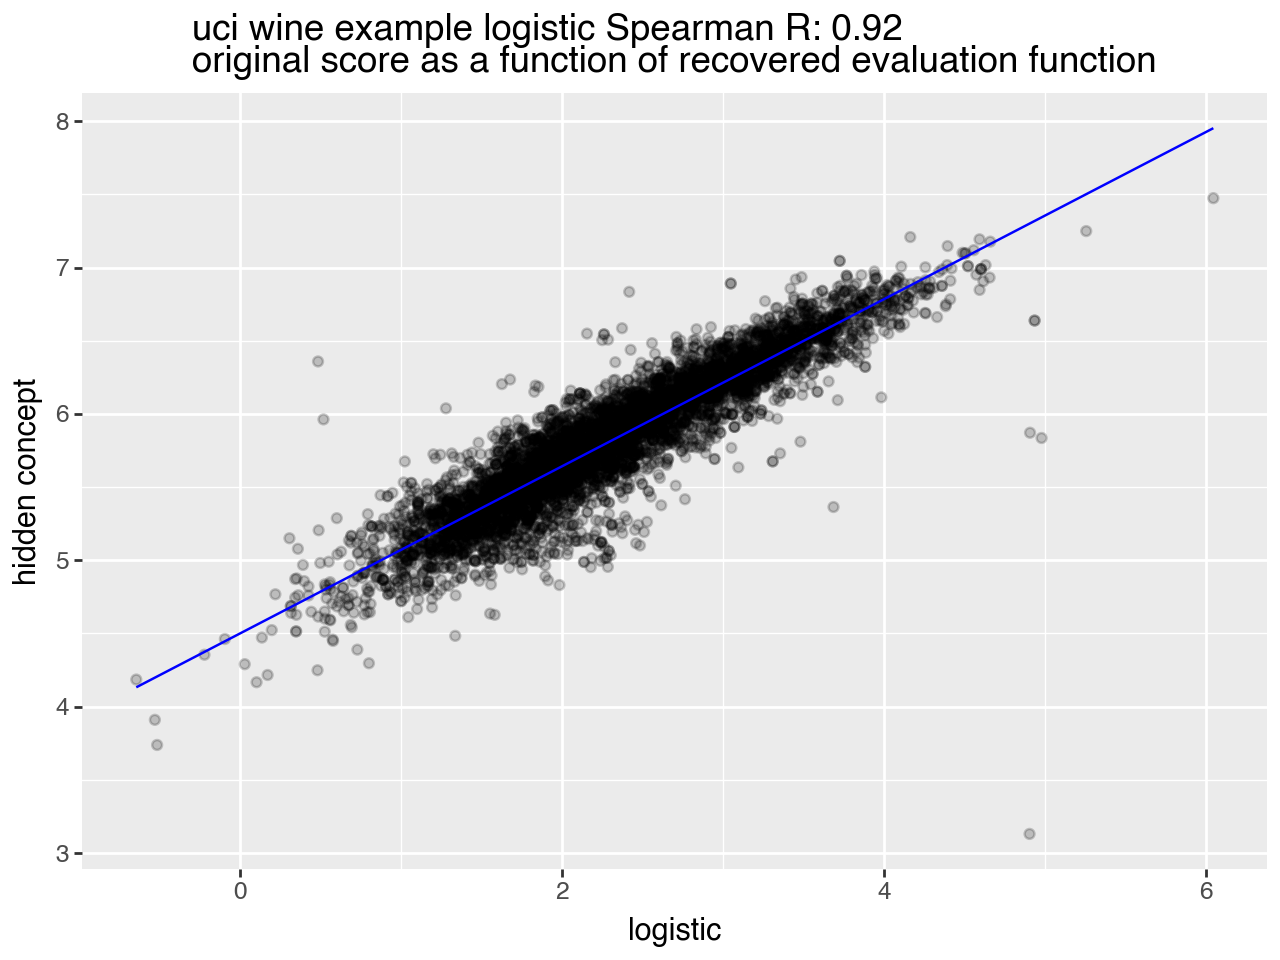

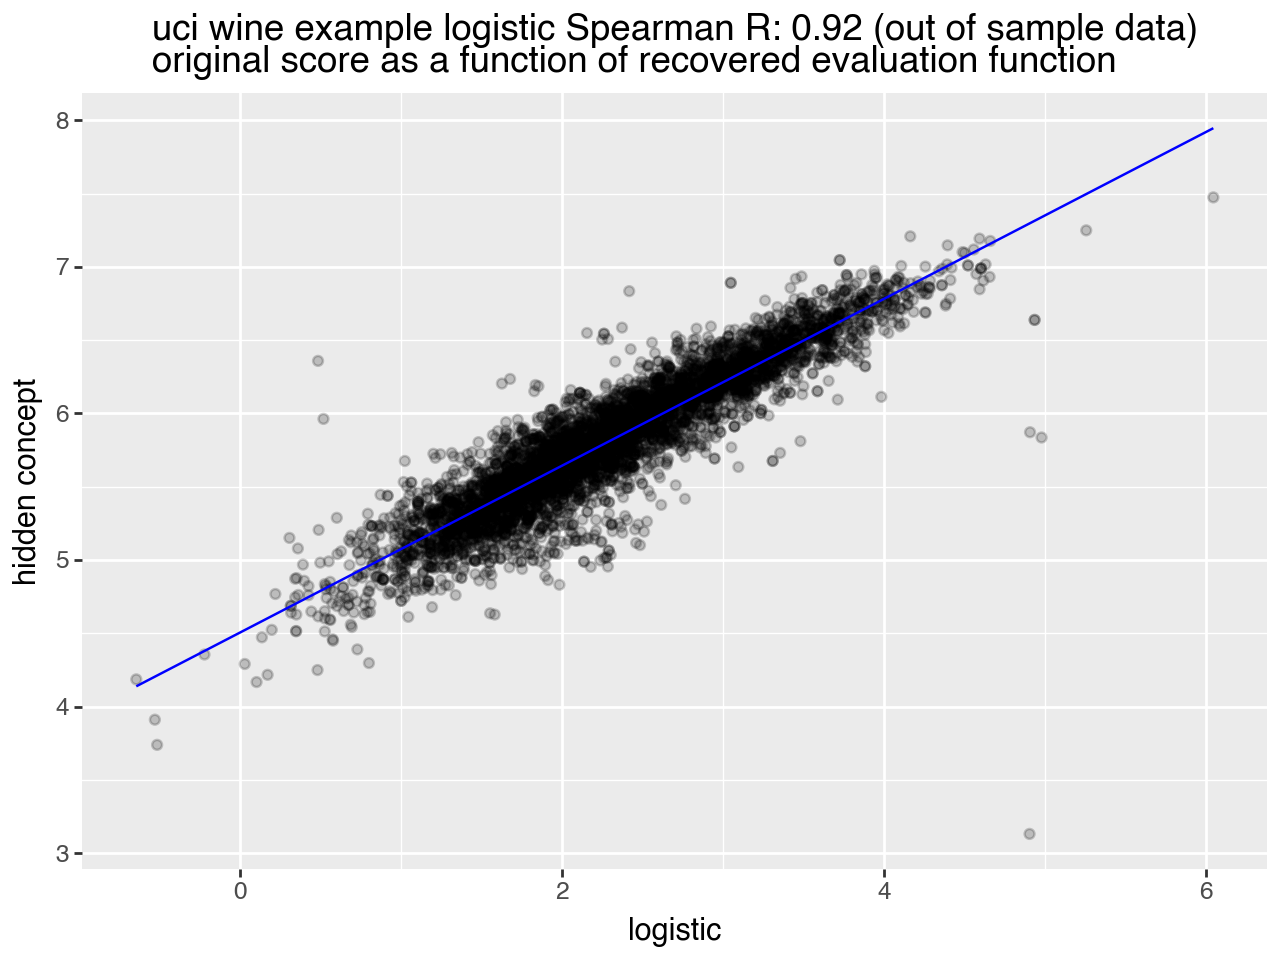

In [31]:
stat_pull = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2068,True
1,0,1,0.1981,False
2,0,2,0.2075,False
3,0,3,0.2062,False
4,0,4,0.1814,False
5,1,0,0.1843,True
6,1,1,0.1973,False
7,1,2,0.2151,False
8,1,3,0.2138,False
9,1,4,0.1895,False


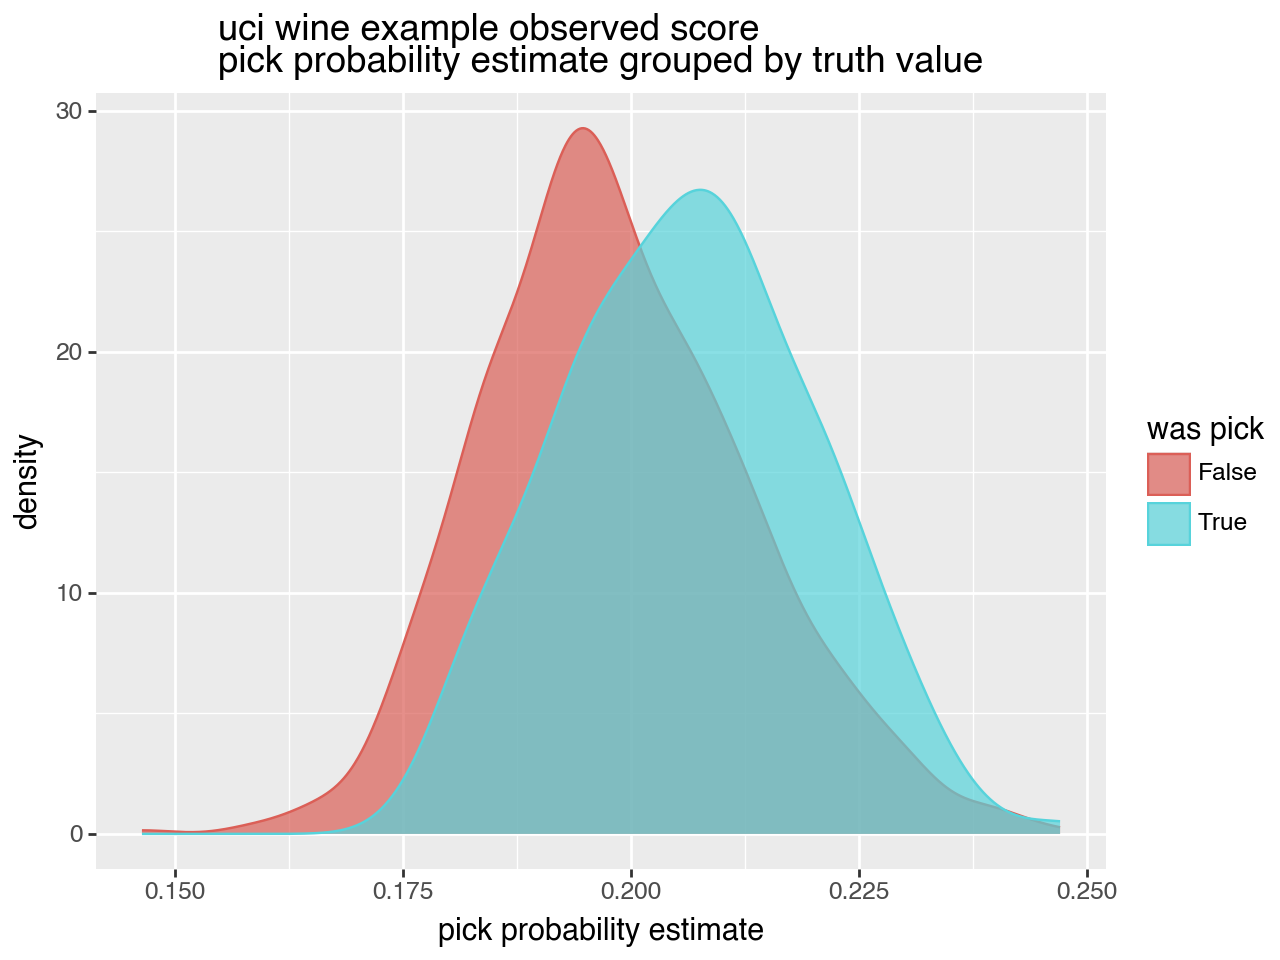

<Figure size 640x480 with 0 Axes>

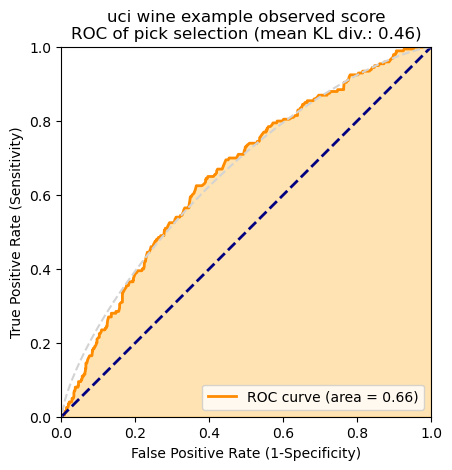

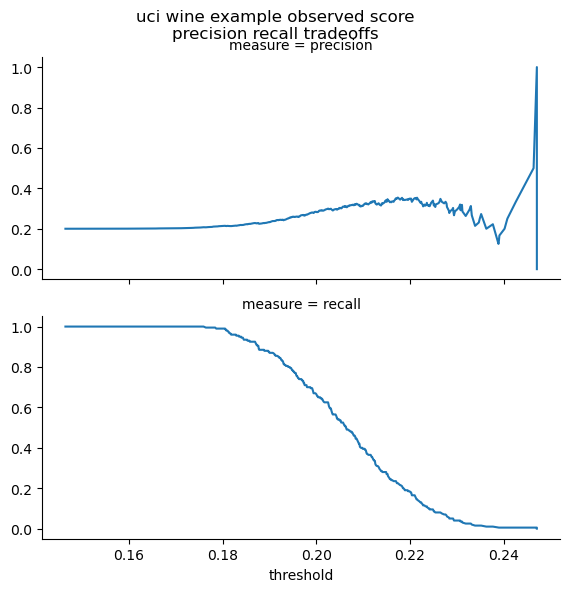

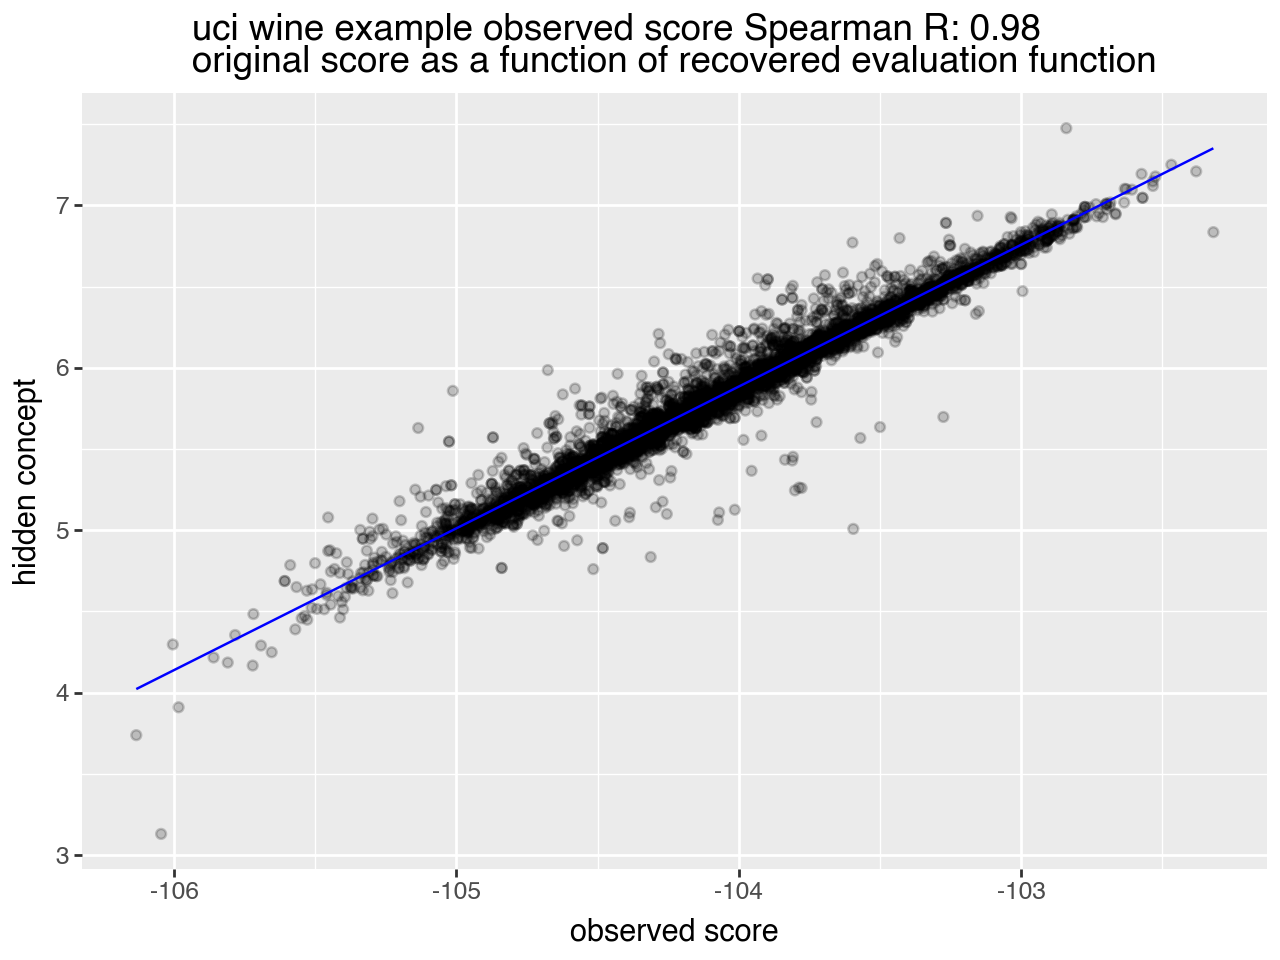

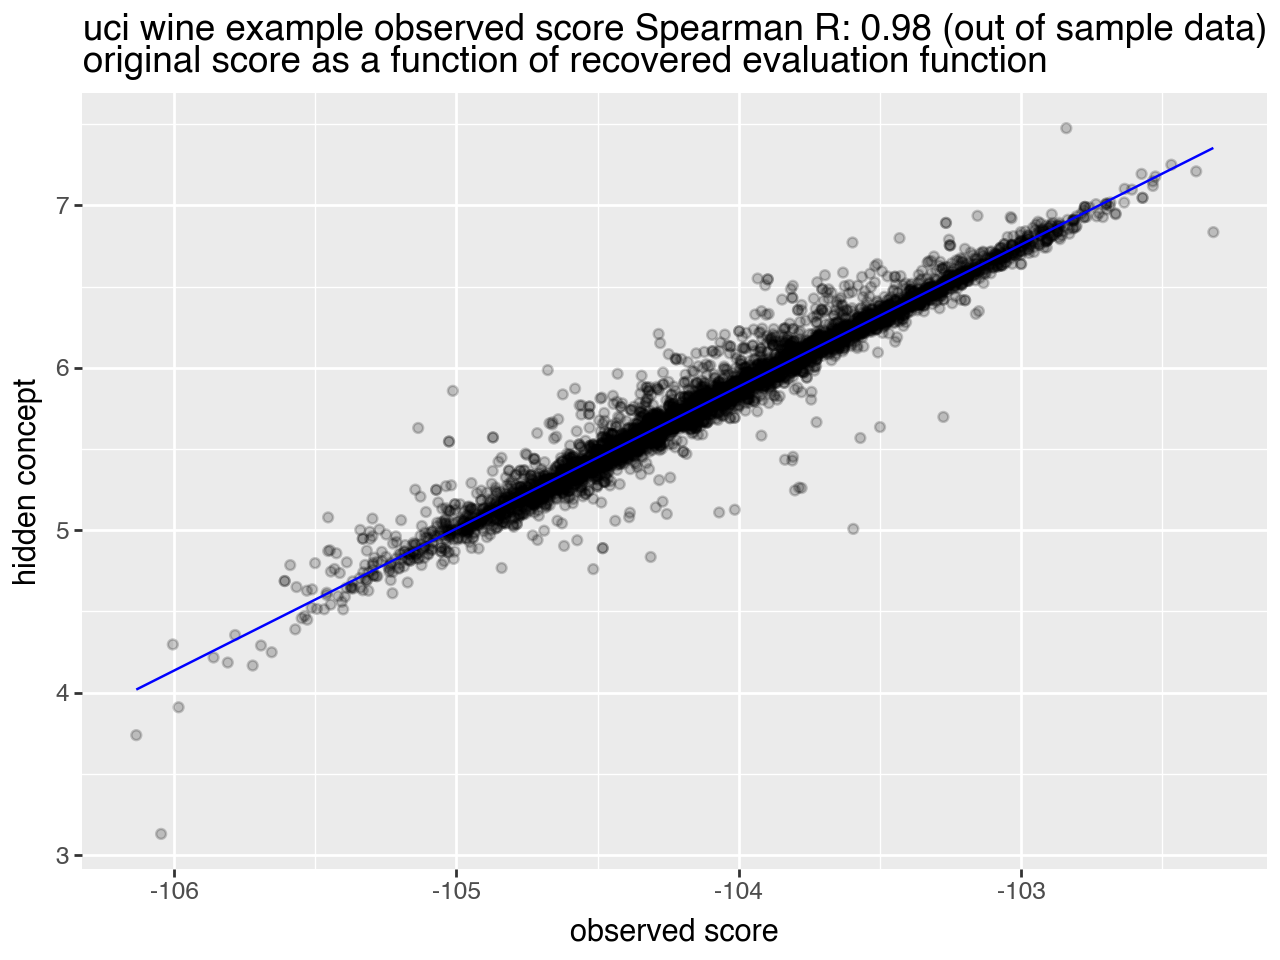

In [32]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [33]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [34]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [35]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.908985,0.909749,0.642397,0.459342,200,200,6497,5575
1,uci wine example,logistic,0.918964,0.918935,0.741353,0.439272,200,200,6497,5575
2,uci wine example,observed score,0.979878,0.979648,0.656991,0.456092,200,200,6497,5575
